In [48]:
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)  # Add project root to path

import cv2
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from utils import label2rgb, get_sorted_files_by_type, set_seed
from lightningmodule.augmentation import load_augmentation
from lightningmodule.constants import CLASSES, CLASS2IND
from argparse import ArgumentParser
from omegaconf import OmegaConf
from lightning.pytorch import seed_everything

from PIL import Image


### 데이터 로드 함수

In [49]:
def load_data(start_index, range):
    image_root = os.path.join('../../../../data/train', 'DCM')
    label_root = os.path.join('../../../../data/train', 'outputs_json')
        
    pngs = get_sorted_files_by_type(image_root, 'png')
    jsons = get_sorted_files_by_type(label_root, 'json')

    train_datalist = {'filenames': pngs, 'labelnames': jsons}

    total_images = len(train_datalist['filenames'])
    
    if start_index + range > total_images:
        print("End index exceeds the total number of images.")
        start_index = total_images - range
    
    image_path = train_datalist['filenames'][start_index:start_index+range]
    label_path = train_datalist['labelnames'][start_index:start_index+range]
                
    return image_path, label_path

### Augmentation 시각화

In [50]:
def visualize_aug(args):
    seed_everything(args.seed)
    set_seed(args.seed)
    
    image_path, label_path = load_data(args.start_index, args.range)
    transforms = load_augmentation(args)
    
    for idx, (image_path, label_path) in enumerate(zip(image_path, label_path)):
        # 이미지와 라벨 로드
        image = cv2.imread(image_path) / 255.0
        
        # 라벨 생성
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
            
        with open(label_path, "r") as f:
            annotations = json.load(f)["annotations"]

        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])
            
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
        # Augmentation 적용
        transformed = transforms(image=image, mask=label)
        transformed_image = transformed['image']
        transformed_label = transformed['mask']
        transformed_label = torch.from_numpy(transformed_label.transpose(2, 0, 1))
        transformed_label = label2rgb(transformed_label)
        
        # 모든 이미지를 PIL Image로 변환
        original_pil = Image.fromarray((image * 255).astype(np.uint8)[..., ::-1])  # BGR to RGB
        transformed_pil = Image.fromarray((transformed_image * 255).astype(np.uint8)[..., ::-1])  # BGR to RGB
        label_pil = Image.fromarray(transformed_label)
        overlap_pil = Image.blend(transformed_pil, label_pil, 0.5)
        
        # Plotting
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1행 4열로 변경, figsize 조정
        
        axs[0].imshow(original_pil)
        axs[0].set_title('Original Image')
        
        axs[1].imshow(transformed_pil)
        axs[1].set_title('Transformed Image')
        
        axs[2].imshow(label_pil)
        axs[2].set_title('Transformed Label')
        
        axs[3].imshow(overlap_pil)
        axs[3].set_title('Overlap Image')
        
        # 각 subplot의 axis 제거 (선택사항)
        for ax in axs:
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

### 실행

Seed set to 42


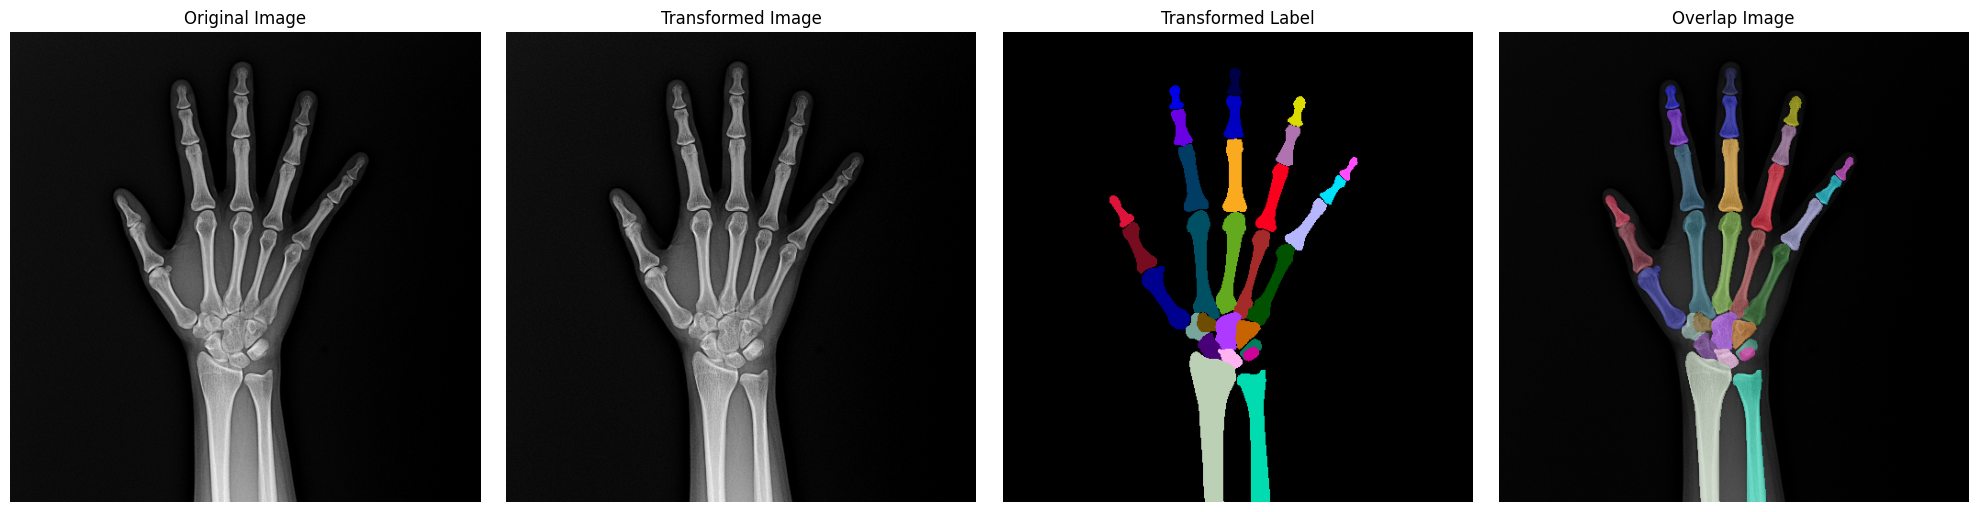

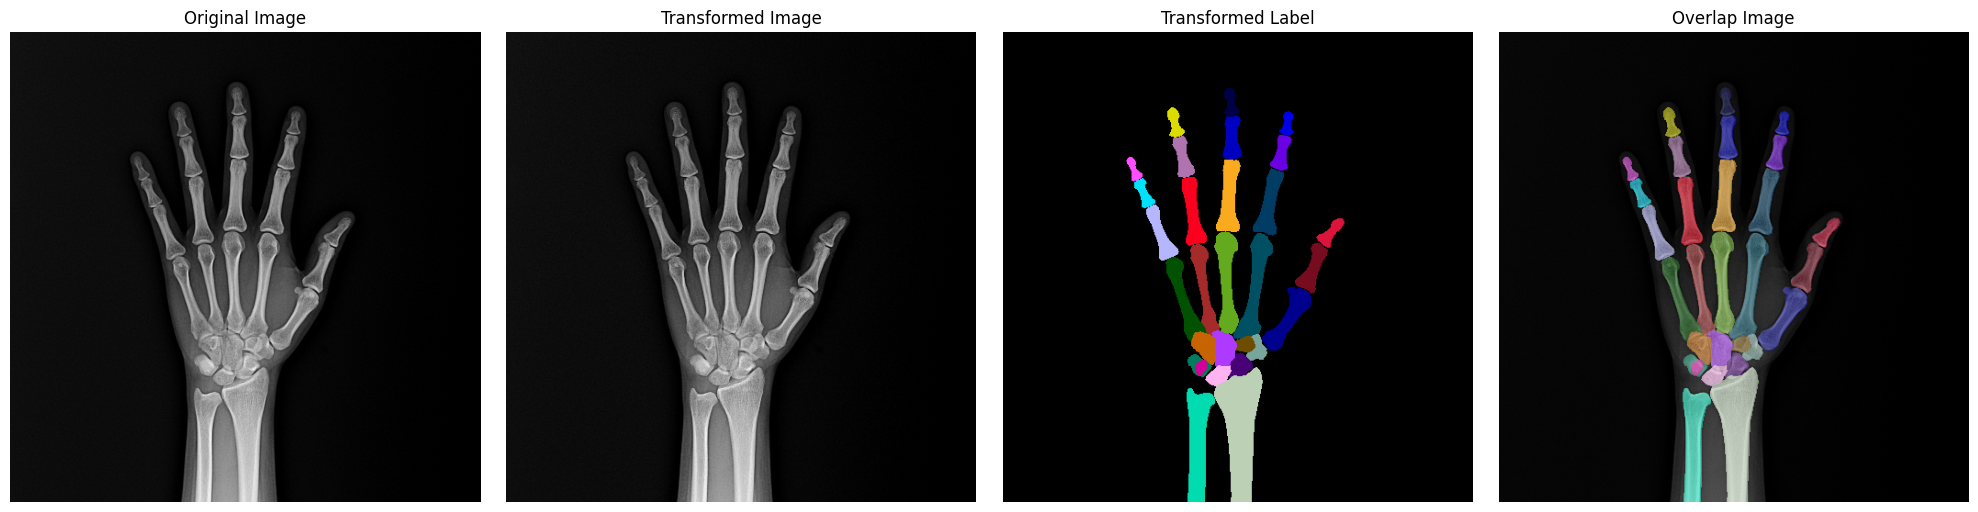

In [51]:
cfg = {
    "seed": 42,
    "input_size": 512, # 이미지 크기
    "start_index": 0, # 시각화할 이미지 시작 인덱스
    "range": 2 # 시각화할 이미지 개수
}
cfg = OmegaConf.create(cfg)

visualize_aug(cfg)